# DEM Pléiades du 14/12/2022 à D47

L'objectif de ce notebook est de comparer les DEMs obtenus par la paire d'image Pléiades acquises le 14/12/2022 aux mesures GNSS concommitantes et antérieures.

## Site d'étude et données
On compare les DEMs Pléiades à 2m aux données GPS qui sont aussi grillées à 2 m (fonction [point2dem d'ASP](https://stereopipeline.readthedocs.io/en/latest/tools/point2dem.html)) dans le fichier `DEM_2m_from_GPS_20221213_and_20221214_clip.tif`

On teste cinq DEMs Pléiades générés par des algorithmes de corrélation différents utilisés dans la fonction [stereo](https://stereopipeline.readthedocs.io/en/latest/tools/stereo.html):
    
    - `SGM_Cesar` signifie semi-global matching avec les paramètres proposés par César Deschamps-Berger
    - `MGM` correspond au script more global matching avec les paramètres proposés par Joaquin Bélart
    - `BM_X_X` ou `BM_kerX` correspond à un block matching avec des fenêtres sous pixel de taille X (en pixels)

In [12]:
import xdem
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

path = 'C:/Users/brunbarf/Data/05_recherche/Pleiades_Antarctique/'

## Co-registration
Les DEMs Pléiades ont une amibuité de positionnement absolu de l'ordre de 5 à 10 m dans toutes les directions. Il faut donc co-registrer les DEMs Pléiades aux données GNSS pour pouvoir les comparer. Pour cela on utilise la méthode de [Nuth and Kääb (2011)](https://tc.copernicus.org/articles/5/271/2011/) implémentée dans [xdem](https://xdem.readthedocs.io/en/latest/coregistration.html).


In [13]:
tba_dem = xdem.DEM(path + 'GPS/DEM_2m_from_GPS_20221213_and_20221214_clip.tif')
ref_dem = xdem.DEM(path + 'Raid_2022-12-14_BM_35_35/Raid_2022-12-14_DEM_2m.tif').reproject(tba_dem, silent=True)
nuth_kaab = xdem.coreg.NuthKaab()
nuth_kaab.fit(ref_dem.data, tba_dem.data, transform=ref_dem.transform)
print(nuth_kaab.to_matrix())

[[ 1.          0.          0.          4.6413998 ]
 [ 0.          1.          0.         -7.86739866]
 [ 0.          0.          1.         11.44341042]
 [ 0.          0.          0.          1.        ]]


In [3]:
tba_dem = xdem.DEM(path + 'GPS/DEM_4m_from_GPS_20221213_and_20221214_clip.tif')
ref_dem = xdem.DEM(path + 'Raid_2022-12-14_BM_35_35/Raid_2022-12-14_DEM_4m.tif').reproject(tba_dem, silent=True)
nuth_kaab = xdem.coreg.NuthKaab()
nuth_kaab.fit(ref_dem.data, tba_dem.data, transform=ref_dem.transform)
print(nuth_kaab.to_matrix())

[[ 1.          0.          0.          9.81970105]
 [ 0.          1.          0.         -6.22148737]
 [ 0.          0.          1.         11.44177619]
 [ 0.          0.          0.          1.        ]]


Les déplacements qui résultent des deux métodes en x et en y sont très différents pour deux résolutions de DEMs différentes, ce qui montre que cette méthode automatique ne marche pas très bien. Cela est du à l'abscence de reliefs avec différentes orientations qui contraignent la co-registration horizontale. En revanche, la co-registration verticale est quasi identique (-11.44 m).
J'ai donc choisi de co-registrer les DEMs à la main. Pour cela, j'utilise les ortho-images qui sont cohérentes avec les DEMs et je mesure "à la main" la distance entre des points remarquables sur l'image (stations météo) et leurs position GPS. J'obtiens une distance moyenne de -6.5 m en x et 7 m en y. J'applique donc des déplacements aux orthos pour vérification et j'applique les mêmes déplacements aux DEMs, avec en plus la différence verticale.

In [4]:
matrix_invert_trans_ortho = np.array(
    [
        [1., 0, 0, -6.5],
        [0, 1, 0, 7],
        [0., 0, 1., 0],
        [0, 0, 0, 1],
    ]
)
matrix_invert_trans_DEM = np.array(
    [
        [1., 0, 0, -6.5],
        [0, 1, 0, 7],
        [0., 0, 1., -11.44177619],
        [0, 0, 0, 1],
    ]
)

On créée de nouveaux geotif co-registrés.

In [5]:
list_process = ['BM_35_35','BM_ker_15', 'BM_ker_51','MGM','SGM_Cesar']

for process in list_process:
    print(process)
    wd = path + 'Raid_2022-12-14_'+process+'/'
    ref_dem = xdem.DEM(wd+'Raid_2022-12-14_DEM_2m.tif')   
    coregis_DEM = xdem.DEM.from_array(
        xdem.coreg.apply_matrix(ref_dem.data.squeeze(), transform=ref_dem.transform, matrix=matrix_invert_trans_DEM),
        transform=ref_dem.transform,
        crs=ref_dem.crs
    )
    coregis_DEM.save(wd+'Raid_2022-12-14_DEM_2m_coregis_GPS.tif')

BM_35_35
BM_ker_15
BM_ker_51
MGM
SGM_Cesar


In [6]:
list_process_ortho = ['BM_35_35','BM_ker_15', 'BM_ker_51','SGM_Cesar']

for process in list_process_ortho:
    print(process)
    wd = path + 'Raid_2022-12-14_'+process+'/'
    ref_dem = xdem.DEM(wd+'Raid_2022-12-14_ortho_0.5m_001_mapproj.tif')
    coregis_DEM = xdem.DEM.from_array(
        xdem.coreg.apply_matrix(ref_dem.data.squeeze(), transform=ref_dem.transform, matrix=matrix_invert_trans_ortho),
        transform=ref_dem.transform,
        crs=ref_dem.crs
    )
    coregis_DEM.save(wd+'Raid_2022-12-14_ortho_0.5m_001_mapproj_coregis_GPS.tif')

BM_35_35
BM_ker_15
BM_ker_51
SGM_Cesar


## Comparaison mesures GPS et DEMs Pléiades à 2 m

L'objectif est de quantifier les différences entre les altitudes GPS et les différents DEMs Pléiades (comparaison directe et comparaison de la dispersion). Notre métrique principale est l'écart-type des différences entre un DEM Pléiades donné et les données GPS (par définition le biais est à zéro).
Dans une optique un peu plus qualitative, on regarde aussi la texture de chaque DEM.

In [14]:
def make_plot(process):
    wd = path + 'Raid_2022-12-14_'+process+'/'
    coregis_dem = xdem.DEM(wd+'Raid_2022-12-14_DEM_2m_coregis_GPS.tif')
    coregis_dem_reproj = xdem.DEM(wd+'Raid_2022-12-14_DEM_2m_coregis_GPS.tif').reproject(GPS_dem, silent=True)
    dh = GPS_dem - coregis_dem_reproj
    GPS_dem_array = GPS_dem.data
    Pl_DEM_array = coregis_dem_reproj.data
    dh_array = dh.data
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    #hist dh GPS-Pleiades
    ax[0].hist(dh_array[~np.isnan(dh_array)], bins = np.arange(-1,1,0.05))
    ax[0].set_xlabel('dh [m]')
    ax[0].set_ylabel('Count')
    ax[0].text(0.1,0.9,'Std.: '+"{:.2f}".format(np.nanstd(dh_array))+' m', transform=ax[0].transAxes)
    ax[0].set_title(process)
    
    #hist elev. GPS and Pl.
    counts, bins_GPS, patches = ax[1].hist(GPS_dem_array[~GPS_dem_array.mask], bins = 50, alpha = 0.5, label = 'GPS')
    counts, bins_GPS, patches = ax[1].hist(Pl_DEM_array[~GPS_dem_array.mask], bins = bins_GPS, alpha = 0.5, label = 'Pleiades')
    ax[1].legend()
    ax[1].set_xlabel('Elev. [m]')
    ax[1].set_ylabel('Count')
    
    fig.tight_layout() # adjusts spacing between subplots
    plt.savefig(path + 'figures/summary_'+process+'.png', dpi = 300, bbox_inches = 'tight')
    
    fig, ax = plt.subplots()
    coregis_dem_reproj.show(ax=ax, vmax = np.max(bins_GPS), vmin = np.min(bins_GPS))
    ax.set_title(process)
    plt.savefig(path + 'figures/DEM_'+process+'.png', dpi = 300, bbox_inches = 'tight')



BM_35_35
BM_ker_15
BM_ker_51
MGM
SGM_Cesar


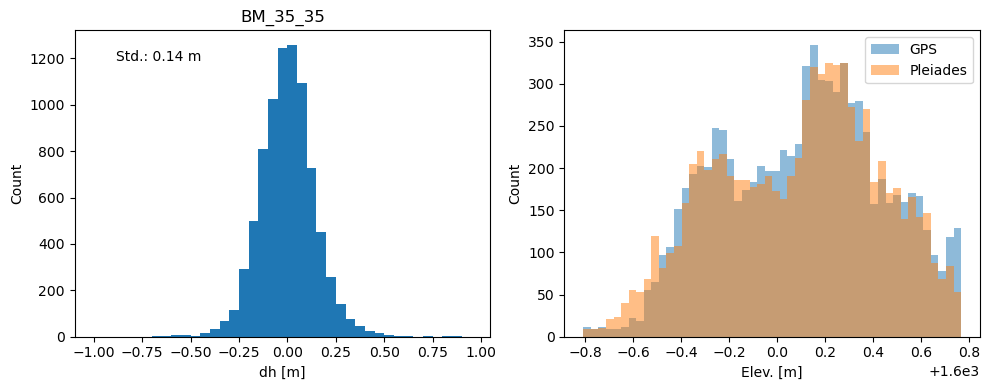

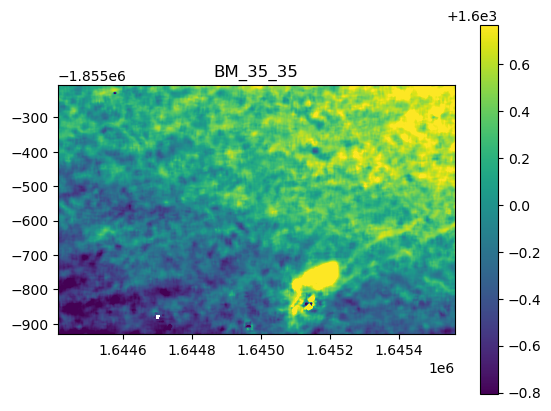

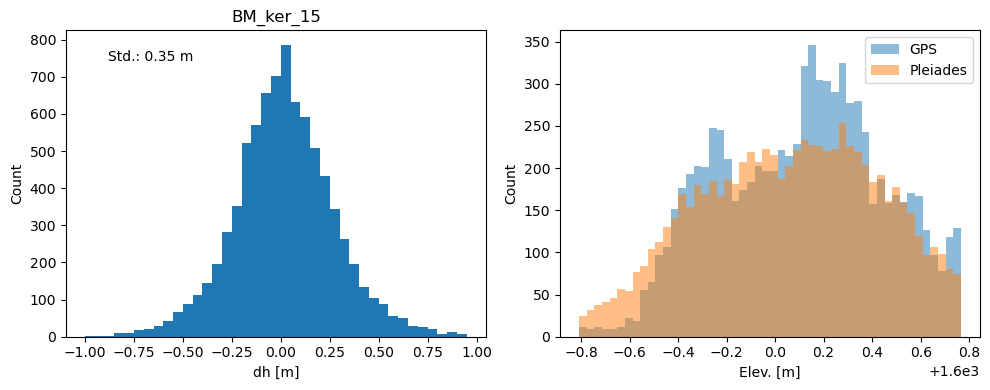

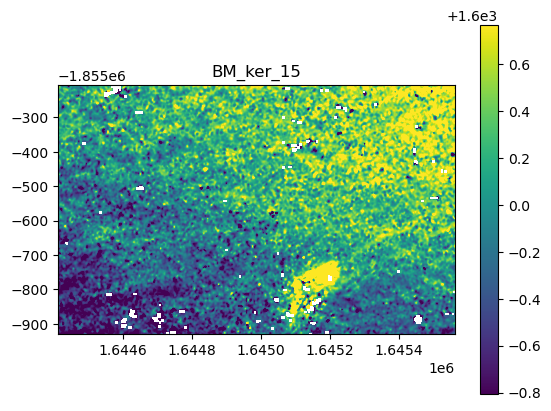

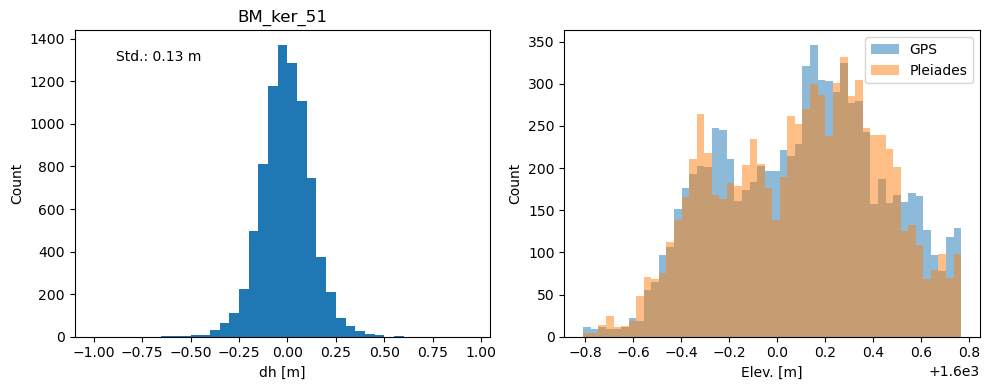

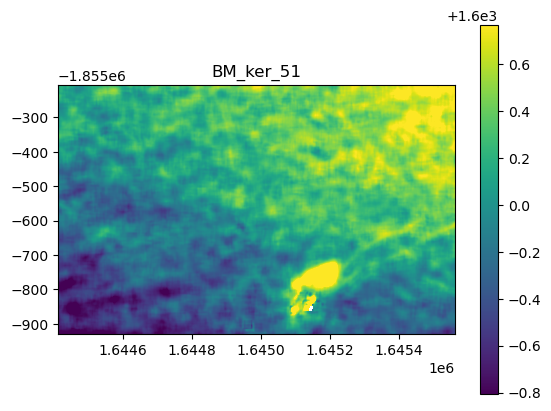

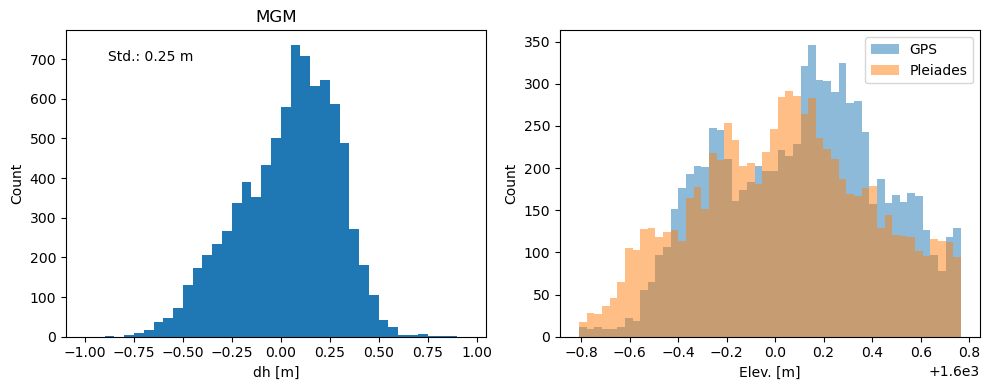

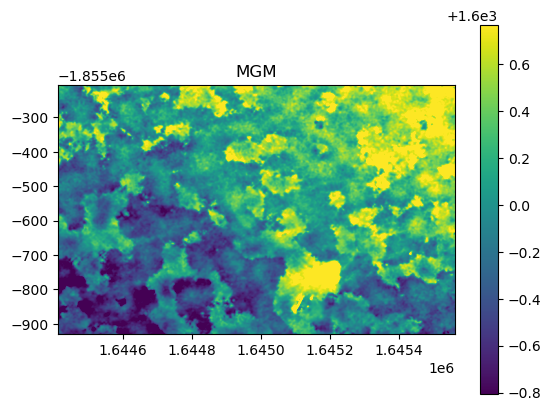

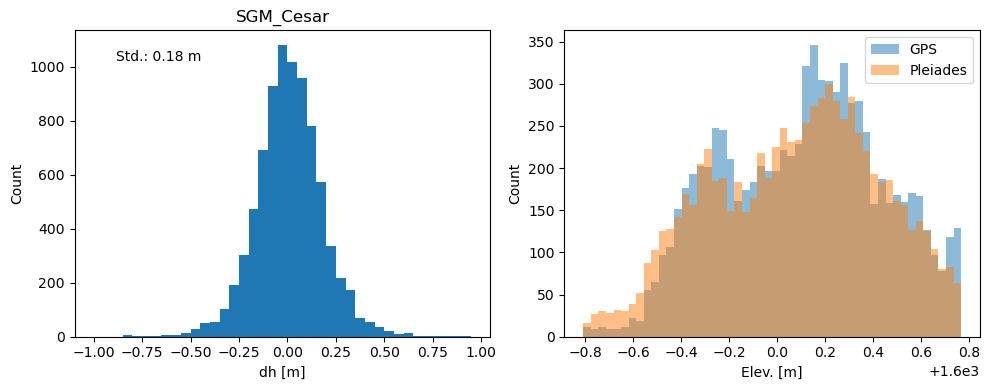

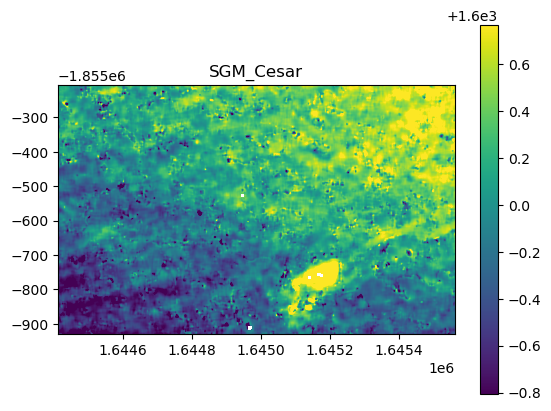

In [15]:
GPS_dem  = xdem.DEM(path + 'GPS/DEM_2m_from_GPS_20221213_and_20221214_clip.tif')
list_process = ['BM_35_35','BM_ker_15', 'BM_ker_51','MGM','SGM_Cesar']
for process in list_process:
    print(process)
    make_plot(process)

## En conclusion ?
Les dispersions sont les plus faibles pour les DEMs obtenus avec de grandes fenêtres de corrélation (`BM_35_35` et `BM_ker51` à 0.14 et 0.13 m, respectivement). A noter : ces dispersions sont très faibles en raison de la surface très plate. Dans des configurations plus chahutées l'écart type des différences entre les DEMs Pléiades et des mesures GNSS sera plutôt de l'ordre de 0.5 m.
De façon qualitative, le `BM_ker51` a une apparence assez lisse, alors que le `BM_35_35` est plus texturé. A ce stade, il est difficile de trancher entre les deux DEMs, mais j'ai tendance à privilégier le `BM_35_35` parce que le `BM_ker51` doit probablement lisser plus fortement la topographie.